# Entrenamiento YOLOv8 - Detecci√≥n de Anomal√≠as Dentales

**Optimizado para RTX 3050 (4GB VRAM) + 16GB RAM**

Este notebook entrena un modelo YOLOv8 para detectar m√∫ltiples anomal√≠as dentales en radiograf√≠as panor√°micas.

## Caracter√≠sticas:
- ‚úÖ YOLOv8n (nano) - optimizado para GPUs peque√±as
- ‚úÖ Mixed Precision (FP16) autom√°tico
- ‚úÖ Data augmentation optimizado para radiograf√≠as
- ‚úÖ Early stopping y checkpointing
- ‚úÖ M√©tricas de detecci√≥n (mAP, Precision, Recall)
- ‚úÖ Visualizaci√≥n de resultados

## Clases a Detectar:
1. Cordal
2. Api√±amiento
3. Diente rotado
4. Diastema
5. Dentula
6. Zona desdentada
7. Tratamiento de conducto
8. Fractura
9. Caries
10. Enanismo reticular
11. Quiste odontog√©nico

## 1. Instalaci√≥n y Setup

In [1]:
# Instalar ultralytics (YOLOv8) si no est√° instalado
import sys
import subprocess

try:
    import ultralytics
    print(f"‚úì Ultralytics ya instalado (versi√≥n {ultralytics.__version__})")
except ImportError:
    print("Instalando ultralytics...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])
    print("‚úì Ultralytics instalado")

‚úì Ultralytics ya instalado (versi√≥n 8.3.220)


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

from ultralytics import YOLO
from ultralytics import settings

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("‚úì Importaciones completadas")

‚úì Importaciones completadas


## 2. Verificar GPU y Configuraci√≥n

In [3]:
print("=" * 80)
print("CONFIGURACI√ìN DE GPU - RTX 3050 OPTIMIZADA")
print("=" * 80)

if torch.cuda.is_available():
    print(f"‚úì PyTorch version: {torch.__version__}")
    print(f"‚úì CUDA version: {torch.version.cuda}")
    print(f"‚úì GPU: {torch.cuda.get_device_name(0)}")
    print(f"‚úì VRAM Total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"‚úì VRAM Disponible: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9:.2f} GB")
    
    # Limpiar cache
    torch.cuda.empty_cache()
    
    device = 0  # GPU 0
    print(f"\n‚úì Dispositivo seleccionado: CUDA:{device}")
else:
    print("‚ö†Ô∏è GPU no disponible - usando CPU (ser√° MUY lento)")
    device = 'cpu'

print("=" * 80)

CONFIGURACI√ìN DE GPU - RTX 3050 OPTIMIZADA
‚úì PyTorch version: 2.5.1+cu121
‚úì CUDA version: 12.1
‚úì GPU: NVIDIA GeForce RTX 3050 Laptop GPU
‚úì VRAM Total: 4.29 GB
‚úì VRAM Disponible: 4.29 GB

‚úì Dispositivo seleccionado: CUDA:0


## 3. Verificar Dataset

In [5]:
# Ruta al archivo de configuraci√≥n del dataset
data_yaml_path = Path('../data.yml')

if not data_yaml_path.exists():
    print(f"‚ö†Ô∏è ERROR: No se encontr√≥ {data_yaml_path}")
else:
    # Leer configuraci√≥n
    with open(data_yaml_path, 'r', encoding='utf-8') as f:
        data_config = yaml.safe_load(f)
    
    print("‚úì Configuraci√≥n del dataset:")
    print(f"  ‚Ä¢ N√∫mero de clases: {data_config['nc']}")
    print(f"  ‚Ä¢ Clases: {data_config['names']}")
    print(f"\n  ‚Ä¢ Train: {data_config['train']}")
    print(f"  ‚Ä¢ Val: {data_config['val']}")
    print(f"  ‚Ä¢ Test: {data_config['test']}")
    
    # Verificar que existen los directorios
    base_dir = Path('..')
    
    train_images = list((base_dir / 'train' / 'images').glob('*.png')) + list((base_dir / 'train' / 'images').glob('*.jpg'))
    val_images = list((base_dir / 'val' / 'images').glob('*.png')) + list((base_dir / 'val' / 'images').glob('*.jpg'))
    test_images = list((base_dir / 'test' / 'images').glob('*.png')) + list((base_dir / 'test' / 'images').glob('*.jpg'))
    
    print(f"\n‚úì Im√°genes encontradas:")
    print(f"  ‚Ä¢ Train: {len(train_images)} im√°genes")
    print(f"  ‚Ä¢ Val: {len(val_images)} im√°genes")
    print(f"  ‚Ä¢ Test: {len(test_images)} im√°genes")
    print(f"  ‚Ä¢ Total: {len(train_images) + len(val_images) + len(test_images)} im√°genes")

‚úì Configuraci√≥n del dataset:
  ‚Ä¢ N√∫mero de clases: 11
  ‚Ä¢ Clases: ['cordal', 'apinamiento', 'diente_rotado', 'diastema', 'dentula', 'zona_dentula', 'tratamiento_conducto', 'fractura', 'caries', 'enanismo_reticular', 'quiste_ontogenico']

  ‚Ä¢ Train: ./train/images
  ‚Ä¢ Val: ./val/images
  ‚Ä¢ Test: ./test/images

‚úì Im√°genes encontradas:
  ‚Ä¢ Train: 31 im√°genes
  ‚Ä¢ Val: 6 im√°genes
  ‚Ä¢ Test: 8 im√°genes
  ‚Ä¢ Total: 45 im√°genes


## 4. Visualizar Ejemplos del Dataset

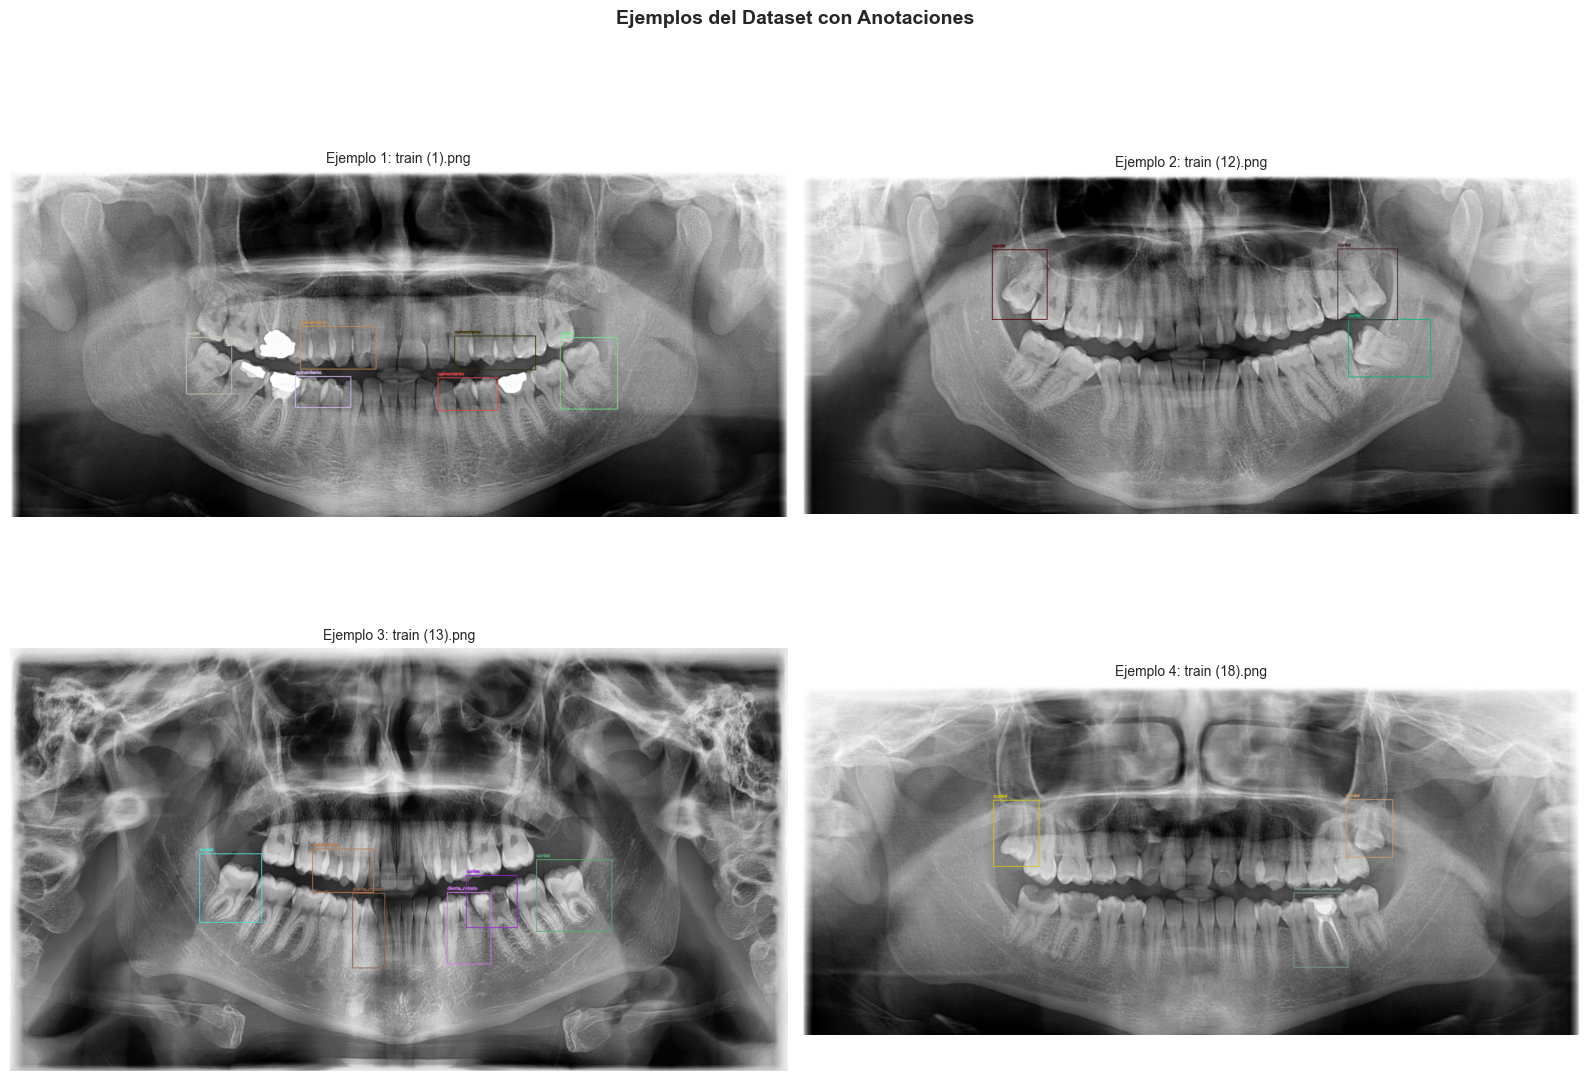

In [6]:
def visualize_yolo_annotations(image_path, label_path, class_names, max_boxes=50):
    """Visualiza una imagen con sus anotaciones YOLO."""
    # Leer imagen
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Leer anotaciones
    if label_path.exists():
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        # Dibujar cada bounding box
        for line in lines[:max_boxes]:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])
                
                # Convertir de YOLO a pixel coordinates
                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)
                
                # Dibujar
                color = tuple(np.random.randint(0, 255, 3).tolist())
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                
                # Etiqueta
                label = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img

# Visualizar algunas im√°genes de ejemplo
if len(train_images) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, img_path in enumerate(train_images[:4]):
        # Buscar archivo de etiquetas correspondiente
        label_path = Path(str(img_path).replace('/images/', '/labels/').replace('\\images\\', '\\labels\\').replace('.png', '.txt').replace('.jpg', '.txt'))
        
        # Visualizar
        img_with_boxes = visualize_yolo_annotations(img_path, label_path, data_config['names'])
        
        axes[i].imshow(img_with_boxes)
        axes[i].set_title(f'Ejemplo {i+1}: {img_path.name}', fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Ejemplos del Dataset con Anotaciones', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("‚ö†Ô∏è No se encontraron im√°genes para visualizar")

## 5. Configuraci√≥n del Entrenamiento (Optimizada para RTX 3050)

In [11]:
# Configuraci√≥n optimizada para RTX 3050 (4GB VRAM)
CONFIG = {
    # Modelo - YOLO Nano es el m√°s ligero
    'model': 'yolov8m.pt',  # Opciones: yolov8n.pt (nano), yolov8s.pt (small), yolov8m.pt (medium)
    
    # Dataset
    'data': str(data_yaml_path.absolute()),
    
    # Entrenamiento - OPTIMIZADO PARA 4GB VRAM
    'epochs': 100,
    'imgsz': 640,  # Tama√±o de imagen (puede reducir a 512 o 384 si da OOM)
    'batch': 8,    # Batch size (ajusta seg√∫n tu VRAM)
    
    # Optimizaci√≥n GPU
    'device': device,
    'workers': 2,   # Workers para data loading
    'amp': True,    # Mixed Precision (FP16) - CR√çTICO para RTX 3050
    'half': False,  # Se activa autom√°ticamente con amp
    
    # Guardado y logging
    'project': '../runs/detect',
    'name': 'dental_yolov8n',
    'exist_ok': True,
    'save': True,
    'save_period': 10,  # Guardar checkpoint cada 10 √©pocas
    
    # Optimizaciones de entrenamiento
    'optimizer': 'AdamW',  # Mejor que SGD para datasets peque√±os
    'lr0': 0.001,          # Learning rate inicial
    'lrf': 0.01,           # Learning rate final (lr0 * lrf)
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,
    
    # Data augmentation (optimizado para radiograf√≠as)
    'hsv_h': 0.015,        # Hue augmentation (muy bajo para rayos X)
    'hsv_s': 0.2,          # Saturation
    'hsv_v': 0.2,          # Value/brightness
    'degrees': 10.0,       # Rotaci√≥n ¬±10 grados
    'translate': 0.1,      # Traslaci√≥n
    'scale': 0.2,          # Escala
    'shear': 5.0,          # Shear
    'perspective': 0.0,    # Sin perspectiva (radiograf√≠as son planas)
    'flipud': 0.0,         # No flip vertical (anatom√≠a tiene orientaci√≥n)
    'fliplr': 0.5,         # Flip horizontal (50% - simetr√≠a dental)
    'mosaic': 1.0,         # Mosaic augmentation
    'mixup': 0.1,          # Mixup augmentation
    'copy_paste': 0.0,     # No copy-paste para este caso
    
    # Early stopping y paciencia
    'patience': 20,        # Parar si no mejora en 20 √©pocas
    
    # Validaci√≥n
    'val': True,
    'plots': True,         # Generar gr√°ficas
    'verbose': True,
    
    # M√©tricas
    'conf': 0.25,          # Confidence threshold para predicciones
    'iou': 0.7,            # IoU threshold para NMS
}

print("=" * 80)
print("CONFIGURACI√ìN DEL ENTRENAMIENTO - YOLOv8")
print("=" * 80)
print(f"Modelo: {CONFIG['model']}")
print(f"Imagen: {CONFIG['imgsz']}x{CONFIG['imgsz']}")
print(f"Batch size: {CONFIG['batch']}")
print(f"√âpocas: {CONFIG['epochs']}")
print(f"Workers: {CONFIG['workers']}")
print(f"Mixed Precision (AMP): {CONFIG['amp']}")
print(f"Device: {CONFIG['device']}")
print(f"Optimizer: {CONFIG['optimizer']}")
print(f"Learning Rate: {CONFIG['lr0']} ‚Üí {CONFIG['lr0'] * CONFIG['lrf']}")
print(f"Early Stopping Patience: {CONFIG['patience']} √©pocas")
print("\n‚ö° Configuraci√≥n optimizada para RTX 3050 (4GB VRAM)")
print("=" * 80)

CONFIGURACI√ìN DEL ENTRENAMIENTO - YOLOv8
Modelo: yolov8m.pt
Imagen: 640x640
Batch size: 8
√âpocas: 100
Workers: 2
Mixed Precision (AMP): True
Device: 0
Optimizer: AdamW
Learning Rate: 0.001 ‚Üí 1e-05
Early Stopping Patience: 20 √©pocas

‚ö° Configuraci√≥n optimizada para RTX 3050 (4GB VRAM)


## 6. Crear Modelo YOLOv8

In [12]:
# Cargar modelo YOLOv8
print(f"Cargando modelo {CONFIG['model']}...")
model = YOLO(CONFIG['model'])

print(f"\n‚úì Modelo cargado: {CONFIG['model']}")
print(f"  ‚Ä¢ Tipo: YOLOv8 Nano (optimizado para velocidad)")
print(f"  ‚Ä¢ Par√°metros: ~{sum(p.numel() for p in model.model.parameters()) / 1e6:.1f}M")
print(f"  ‚Ä¢ Pre-entrenado: COCO dataset (transferencia de aprendizaje)")
print(f"\nüìù Nota: El modelo se ajustar√° autom√°ticamente a {data_config['nc']} clases")

Cargando modelo yolov8m.pt...

‚úì Modelo cargado: yolov8m.pt
  ‚Ä¢ Tipo: YOLOv8 Nano (optimizado para velocidad)
  ‚Ä¢ Par√°metros: ~25.9M
  ‚Ä¢ Pre-entrenado: COCO dataset (transferencia de aprendizaje)

üìù Nota: El modelo se ajustar√° autom√°ticamente a 11 clases


## 7. Entrenar Modelo üöÄ

**IMPORTANTE**: Este proceso tomar√° tiempo dependiendo de:
- N√∫mero de im√°genes en tu dataset
- Configuraci√≥n de √©pocas (100)
- Hardware (RTX 3050)

**Tiempo estimado**: 2-5 horas para 100 √©pocas con dataset peque√±o-mediano

In [13]:
import time
from datetime import datetime

print("=" * 80)
print("INICIANDO ENTRENAMIENTO - YOLOv8")
print("=" * 80)
print(f"Fecha/Hora inicio: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)
print("\n‚è≥ Esto puede tomar varias horas...")
print("üí° Tip: No uses el PC para tareas pesadas mientras entrena\n")

start_time = time.time()

# ENTRENAR
results = model.train(
    data=CONFIG['data'],
    epochs=CONFIG['epochs'],
    imgsz=CONFIG['imgsz'],
    batch=CONFIG['batch'],
    device=CONFIG['device'],
    workers=CONFIG['workers'],
    amp=CONFIG['amp'],
    project=CONFIG['project'],
    name=CONFIG['name'],
    exist_ok=CONFIG['exist_ok'],
    save=CONFIG['save'],
    save_period=CONFIG['save_period'],
    optimizer=CONFIG['optimizer'],
    lr0=CONFIG['lr0'],
    lrf=CONFIG['lrf'],
    momentum=CONFIG['momentum'],
    weight_decay=CONFIG['weight_decay'],
    warmup_epochs=CONFIG['warmup_epochs'],
    warmup_momentum=CONFIG['warmup_momentum'],
    warmup_bias_lr=CONFIG['warmup_bias_lr'],
    hsv_h=CONFIG['hsv_h'],
    hsv_s=CONFIG['hsv_s'],
    hsv_v=CONFIG['hsv_v'],
    degrees=CONFIG['degrees'],
    translate=CONFIG['translate'],
    scale=CONFIG['scale'],
    shear=CONFIG['shear'],
    perspective=CONFIG['perspective'],
    flipud=CONFIG['flipud'],
    fliplr=CONFIG['fliplr'],
    mosaic=CONFIG['mosaic'],
    mixup=CONFIG['mixup'],
    copy_paste=CONFIG['copy_paste'],
    patience=CONFIG['patience'],
    val=CONFIG['val'],
    plots=CONFIG['plots'],
    verbose=CONFIG['verbose'],
    conf=CONFIG['conf'],
    iou=CONFIG['iou']
)

end_time = time.time()
total_time = end_time - start_time

print("\n" + "=" * 80)
print("ENTRENAMIENTO COMPLETADO ‚úÖ")
print("=" * 80)
print(f"Fecha/Hora fin: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Tiempo total: {total_time/3600:.2f} horas ({total_time/60:.1f} minutos)")
print(f"Tiempo por √©poca: {total_time/CONFIG['epochs']:.1f} segundos")
print("=" * 80)

INICIANDO ENTRENAMIENTO - YOLOv8
Fecha/Hora inicio: 2025-10-23 01:12:14

‚è≥ Esto puede tomar varias horas...
üí° Tip: No uses el PC para tareas pesadas mientras entrena

Ultralytics 8.3.220  Python-3.12.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=0.25, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\notebooks\..\data.yml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2, hsv_v=0.2, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ra

## 8. Resultados del Entrenamiento

In [14]:
# Directorio de resultados
results_dir = Path(CONFIG['project']) / CONFIG['name']
print(f"üìÅ Directorio de resultados: {results_dir}\n")

# Mostrar m√©tricas finales
print("=" * 80)
print("M√âTRICAS FINALES")
print("=" * 80)

# Las m√©tricas est√°n en results.results_dict
metrics = results.results_dict
print(f"\nüìä M√©tricas de Detecci√≥n:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):
        print(f"  ‚Ä¢ {key}: {value:.4f}")

print("\n" + "=" * 80)

üìÅ Directorio de resultados: ..\runs\detect\dental_yolov8n

M√âTRICAS FINALES

üìä M√©tricas de Detecci√≥n:
  ‚Ä¢ metrics/precision(B): 0.7846
  ‚Ä¢ metrics/recall(B): 0.4090
  ‚Ä¢ metrics/mAP50(B): 0.5939
  ‚Ä¢ metrics/mAP50-95(B): 0.4078
  ‚Ä¢ fitness: 0.4078



## 9. Visualizar Curvas de Entrenamiento

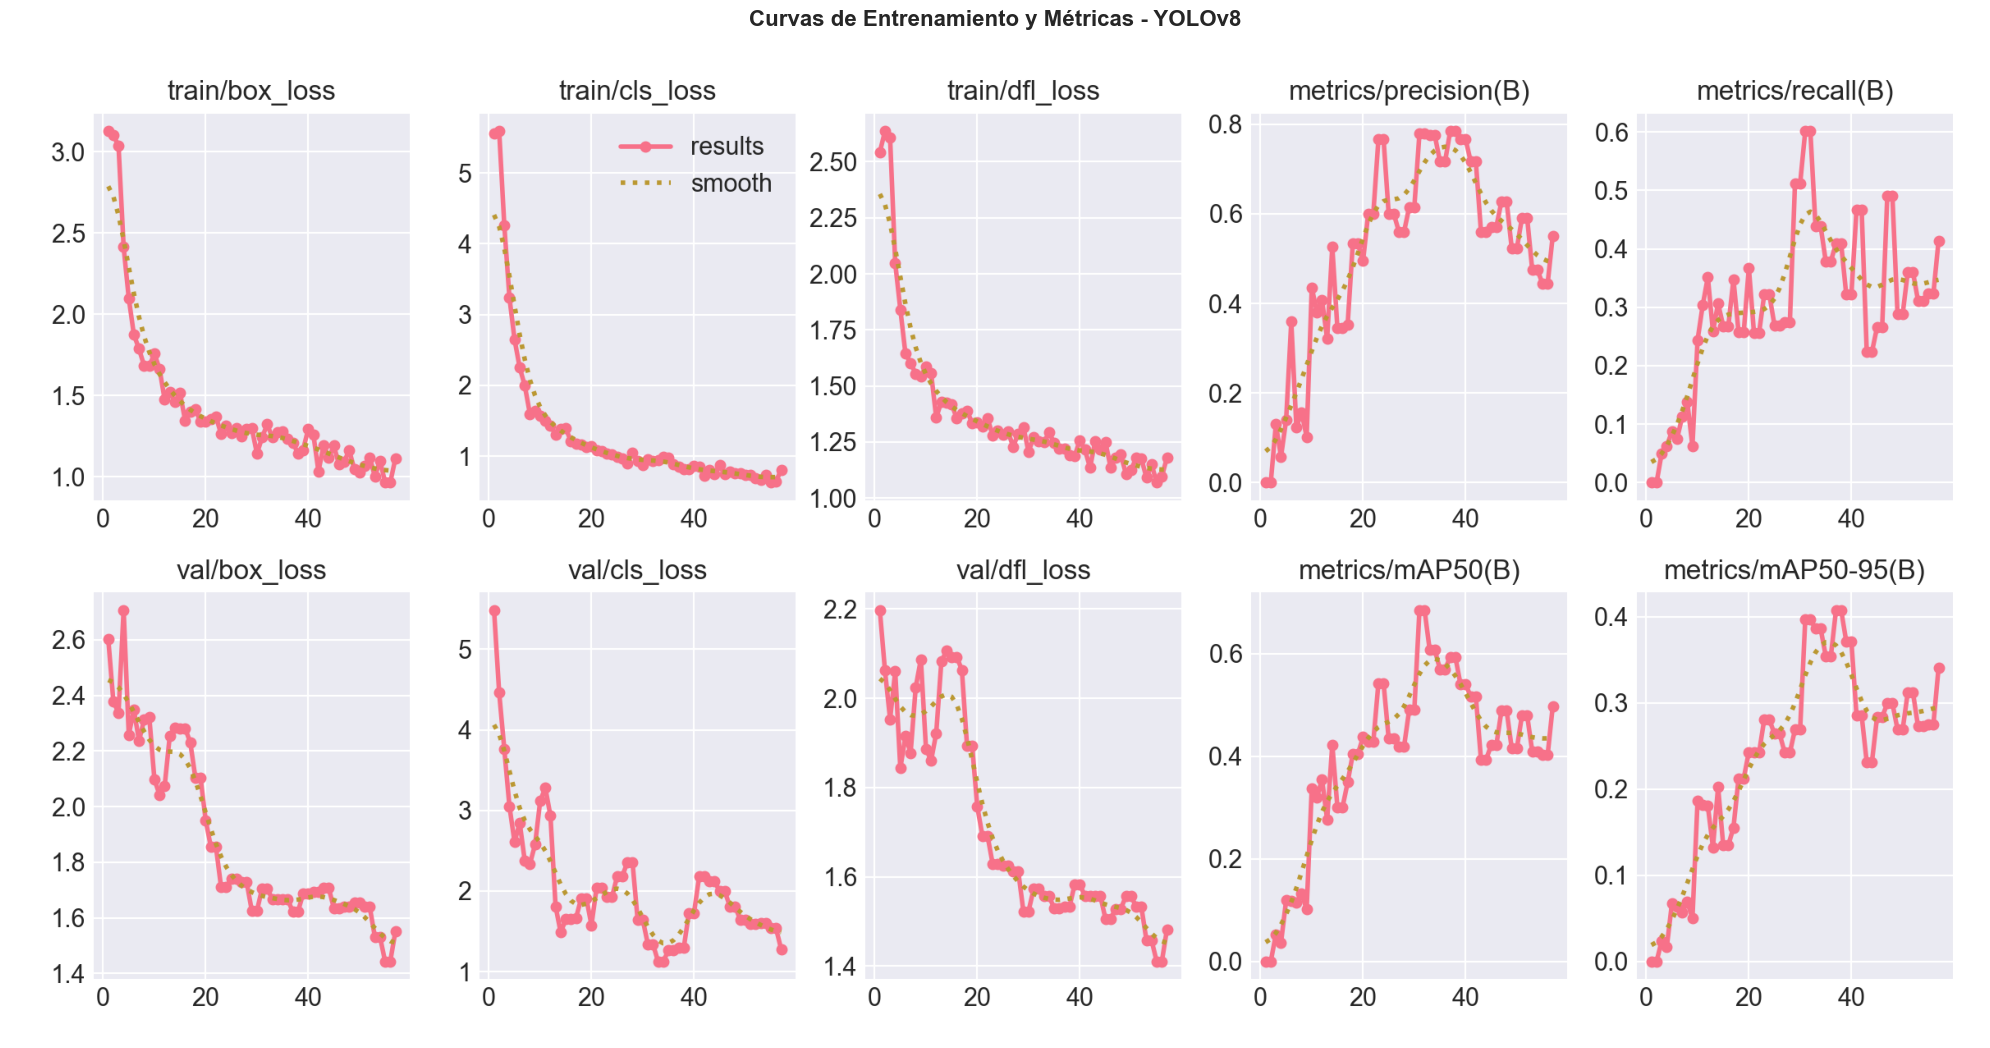

In [15]:
# Cargar imagen de resultados generada por YOLO
results_img_path = results_dir / 'results.png'

if results_img_path.exists():
    img = Image.open(results_img_path)
    
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Curvas de Entrenamiento y M√©tricas - YOLOv8', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print(f"‚ö†Ô∏è No se encontr√≥ {results_img_path}")
    print("Las gr√°ficas se generaron en el directorio de resultados.")

## 10. Confusion Matrix

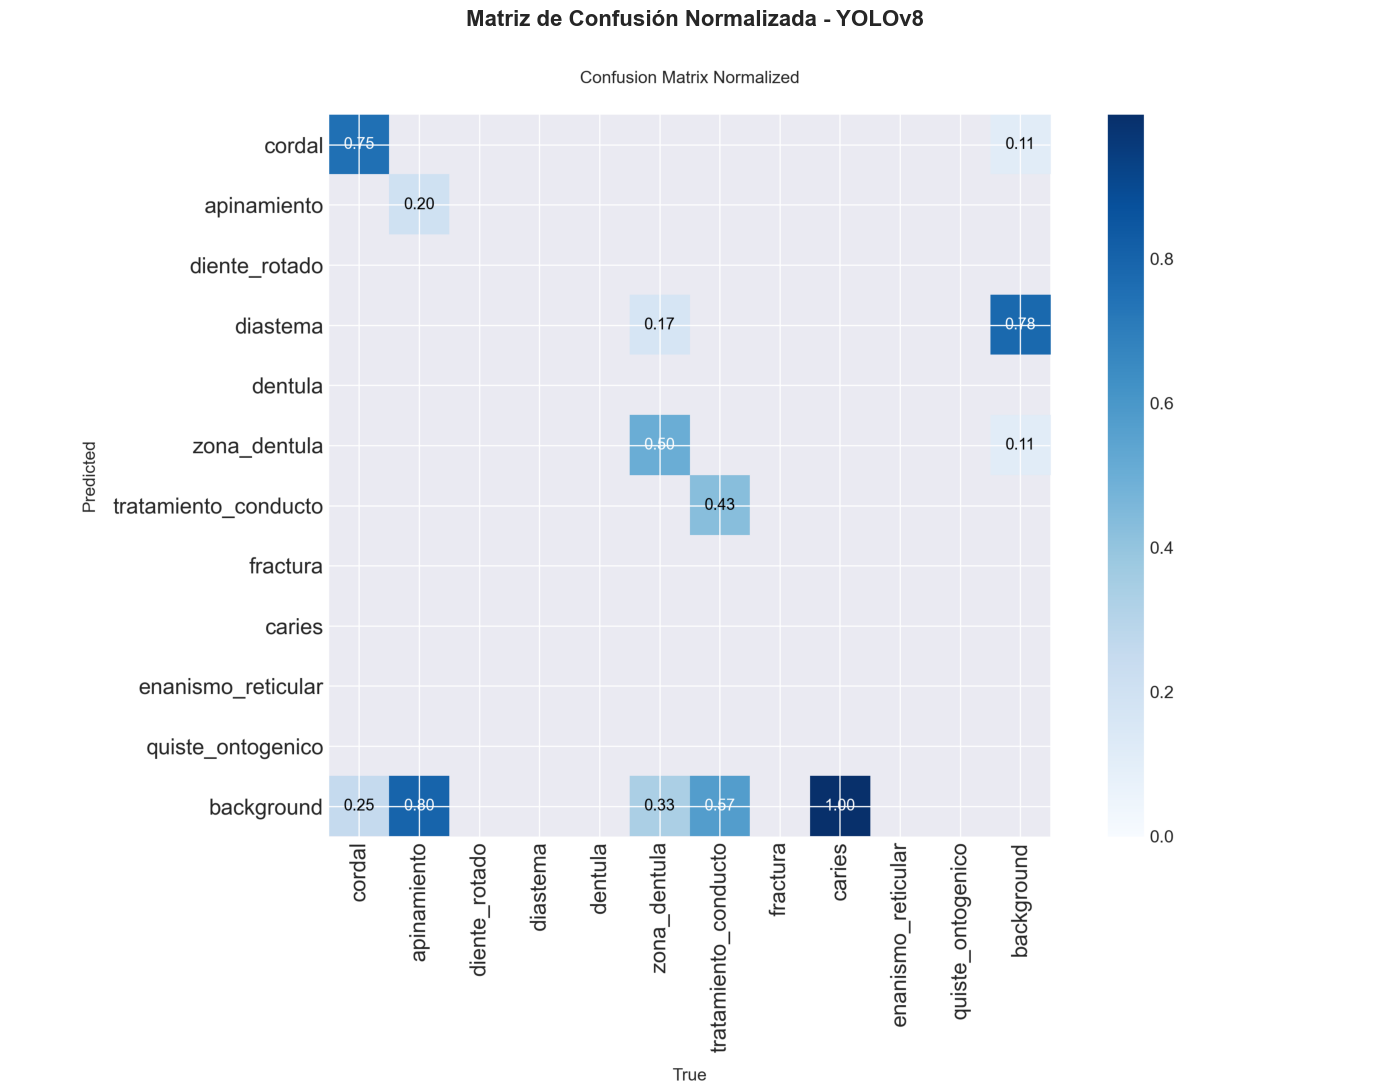

In [16]:
# Cargar matriz de confusi√≥n
confusion_matrix_path = results_dir / 'confusion_matrix_normalized.png'

if confusion_matrix_path.exists():
    img = Image.open(confusion_matrix_path)
    
    fig, ax = plt.subplots(figsize=(14, 12))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Matriz de Confusi√≥n Normalizada - YOLOv8', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print(f"‚ö†Ô∏è No se encontr√≥ matriz de confusi√≥n en {confusion_matrix_path}")

## 11. Validar en Test Set

In [17]:
print("Validando en test set...\n")

# Cargar mejor modelo
best_model_path = results_dir / 'weights' / 'best.pt'
model_best = YOLO(best_model_path)

# Validar
test_results = model_best.val(
    data=CONFIG['data'],
    split='test',
    imgsz=CONFIG['imgsz'],
    batch=CONFIG['batch'],
    conf=CONFIG['conf'],
    iou=CONFIG['iou'],
    device=CONFIG['device']
)

print("\n" + "=" * 80)
print("RESULTADOS EN TEST SET")
print("=" * 80)
print(f"\nüìä M√©tricas de Test:")
for key, value in test_results.results_dict.items():
    if isinstance(value, (int, float)):
        print(f"  ‚Ä¢ {key}: {value:.4f}")
print("\n" + "=" * 80)

Validando en test set...

Ultralytics 8.3.220  Python-3.12.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 92 layers, 25,846,129 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.30.2 ms, read: 942.9113.9 MB/s, size: 2463.4 KB)
val: Scanning C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\test\labels.cache... 8 images, 0 backgrounds, 0 corrupt: 100% ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8/8 6.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1/1 0.3it/s 3.7s
                   all          8         33        0.5      0.311       0.43      0.288
                cordal          6         18          1      0.611      0.806      0.537
           apinamiento          2          3          0          0          0          0
         diente_rotado          1          1          0          0          0          0
   

## 12. Ejemplos de Predicciones

Realizando predicciones en im√°genes de test...



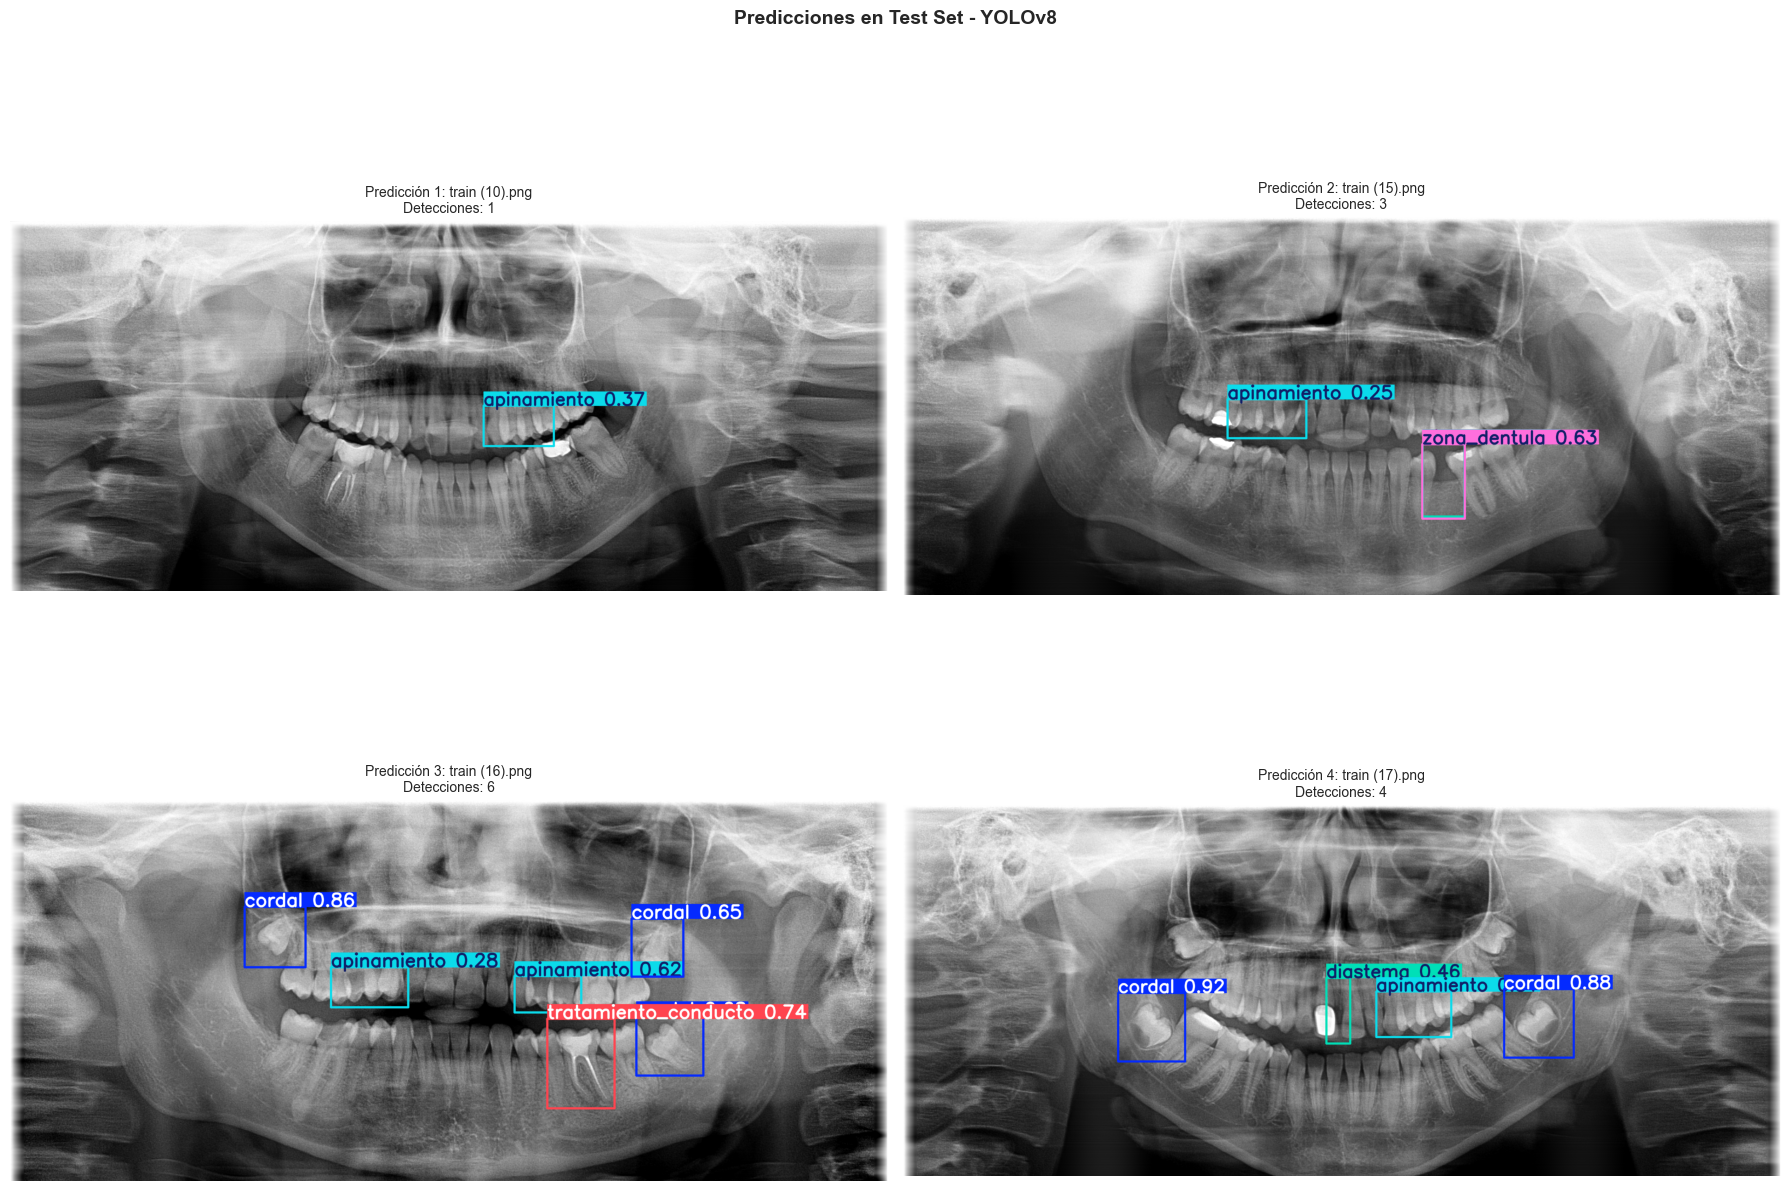


DETALLES DE DETECCIONES

Imagen 1: train (10).png
  Total de detecciones: 1
    1. apinamiento: 37.40% confianza

Imagen 2: train (15).png
  Total de detecciones: 3
    1. zona_dentula: 63.31% confianza
    2. diastema: 28.48% confianza
    3. apinamiento: 25.09% confianza

Imagen 3: train (16).png
  Total de detecciones: 6
    1. cordal: 86.13% confianza
    2. tratamiento_conducto: 73.61% confianza
    3. cordal: 67.91% confianza
    4. cordal: 64.69% confianza
    5. apinamiento: 61.57% confianza
    6. apinamiento: 28.49% confianza

Imagen 4: train (17).png
  Total de detecciones: 4
    1. cordal: 92.23% confianza
    2. cordal: 88.35% confianza
    3. apinamiento: 51.34% confianza
    4. diastema: 45.58% confianza


In [18]:
# Hacer predicciones en im√°genes de test
if len(test_images) > 0:
    print("Realizando predicciones en im√°genes de test...\n")
    
    # Seleccionar algunas im√°genes
    sample_images = test_images[:min(4, len(test_images))]
    
    # Predecir
    predictions = model_best.predict(
        source=[str(img) for img in sample_images],
        conf=CONFIG['conf'],
        iou=CONFIG['iou'],
        imgsz=CONFIG['imgsz'],
        device=CONFIG['device'],
        save=False,
        verbose=False
    )
    
    # Visualizar
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    for i, (pred, img_path) in enumerate(zip(predictions, sample_images)):
        # Obtener imagen con predicciones
        img_with_pred = pred.plot()  # Dibuja las predicciones
        img_with_pred = cv2.cvtColor(img_with_pred, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img_with_pred)
        axes[i].set_title(f'Predicci√≥n {i+1}: {img_path.name}\nDetecciones: {len(pred.boxes)}', fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Predicciones en Test Set - YOLOv8', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Mostrar detalles de detecciones
    print("\n" + "=" * 80)
    print("DETALLES DE DETECCIONES")
    print("=" * 80)
    for i, pred in enumerate(predictions):
        print(f"\nImagen {i+1}: {sample_images[i].name}")
        print(f"  Total de detecciones: {len(pred.boxes)}")
        
        if len(pred.boxes) > 0:
            for j, box in enumerate(pred.boxes):
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                cls_name = data_config['names'][cls_id]
                print(f"    {j+1}. {cls_name}: {conf:.2%} confianza")
        else:
            print("    (Sin detecciones)")
else:
    print("‚ö†Ô∏è No hay im√°genes de test disponibles")

## 13. Exportar Modelo para Producci√≥n (Opcional)

In [ ]:
# Exportar a ONNX para deployment
print("Exportando modelo a formato ONNX...\n")

onnx_path = model_best.export(
    format='onnx',
    imgsz=CONFIG['imgsz'],
    dynamic=False,
    simplify=True
)

print(f"\n‚úì Modelo exportado a: {onnx_path}")
print("  Este formato puede usarse para deployment en producci√≥n")

## 14. Resumen Final

In [ ]:
print("\n" + "=" * 80)
print("RESUMEN FINAL DEL ENTRENAMIENTO - YOLOv8")
print("=" * 80)

print(f"\nüìä Configuraci√≥n:")
print(f"  ‚Ä¢ Modelo: {CONFIG['model']}")
print(f"  ‚Ä¢ Dataset: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")
print(f"  ‚Ä¢ Clases: {data_config['nc']} ({', '.join(data_config['names'][:3])}...)")
print(f"  ‚Ä¢ Imagen: {CONFIG['imgsz']}x{CONFIG['imgsz']}")
print(f"  ‚Ä¢ Batch: {CONFIG['batch']}")
print(f"  ‚Ä¢ √âpocas: {CONFIG['epochs']}")
print(f"  ‚Ä¢ Tiempo total: {total_time/3600:.2f} horas")

print(f"\nüéØ Resultados:")
print(f"  ‚Ä¢ mAP50: {test_results.results_dict.get('metrics/mAP50(B)', 0):.4f}")
print(f"  ‚Ä¢ mAP50-95: {test_results.results_dict.get('metrics/mAP50-95(B)', 0):.4f}")
print(f"  ‚Ä¢ Precision: {test_results.results_dict.get('metrics/precision(B)', 0):.4f}")
print(f"  ‚Ä¢ Recall: {test_results.results_dict.get('metrics/recall(B)', 0):.4f}")

print(f"\nÔøΩÔøΩ Archivos generados:")
print(f"  ‚Ä¢ Mejor modelo: {best_model_path}")
print(f"  ‚Ä¢ Resultados: {results_dir}")
print(f"  ‚Ä¢ Gr√°ficas: {results_dir}/results.png")
print(f"  ‚Ä¢ Matriz confusi√≥n: {results_dir}/confusion_matrix_normalized.png")

print(f"\nüí° Pr√≥ximos pasos:")
print(f"  1. Revisar las gr√°ficas de entrenamiento en: {results_dir}")
print(f"  2. Analizar la matriz de confusi√≥n para identificar clases problem√°ticas")
print(f"  3. Probar predicciones en nuevas im√°genes")
print(f"  4. Si el rendimiento no es satisfactorio:")
print(f"     - Aumentar datos de entrenamiento")
print(f"     - Ajustar augmentations")
print(f"     - Probar modelo m√°s grande (yolov8s.pt o yolov8m.pt)")
print(f"     - Ajustar hiperpar√°metros")

print("\n" + "=" * 80)
print("‚úÖ ENTRENAMIENTO YOLOv8 COMPLETADO EXITOSAMENTE")
print("=" * 80)

## 15. Limpiar Memoria GPU

In [ ]:
# Liberar memoria GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("‚úì Cache de GPU limpiada")
    print(f"  VRAM disponible: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9:.2f} GB")

---

## üéì Notas Importantes

### Interpretaci√≥n de M√©tricas:
- **mAP50**: Mean Average Precision @ IoU=0.5 (m√©trica principal)
- **mAP50-95**: mAP promediado entre IoU 0.5 a 0.95 (m√°s estricta)
- **Precision**: De las detecciones, cu√°ntas son correctas
- **Recall**: De todos los objetos reales, cu√°ntos fueron detectados

### Valores buenos para detecci√≥n m√©dica:
- mAP50 > 0.7: Bueno
- mAP50 > 0.8: Muy bueno
- mAP50 > 0.9: Excelente

### Si el entrenamiento es muy lento:
1. Reduce `imgsz` a 512 o 384
2. Reduce `batch` a 4
3. Reduce `workers` a 1
4. Aseg√∫rate que no haya otros programas usando GPU

### Si tienes CUDA Out of Memory:
1. Reduce `batch` a 4 o 2
2. Reduce `imgsz` a 512 o 384
3. Cierra otros programas que usen GPU
4. Reinicia el kernel de Jupyter

### Diferencias entre YOLOv8 y YOLOv11:
- **YOLOv8**: Versi√≥n madura y estable, ampliamente probada
- **YOLOv11**: Versi√≥n m√°s reciente con mejoras incrementales
- Ambas funcionan de manera similar para este caso de uso